# | HW3 | MobileNetV2 변형해 보기

**Due: 1/16, 11:59 PM**

- **채점 기준**
  - 아래 과제 설명을 따라야한다.
  - test accuracy가 **80% 이상** 나와야 한다.
- **제출**
  - "HW3_학번_이름.ipynb" 형태로 저장하여 Jupyter Notebook을 그대로 제출.
    - 예: HW3_2022_12345_keondo.ipynb
  - output 지우지 말아 주세요

---

`BatchNormalization(axis, momentum, epsilon)` : https://keras.io/api/layers/normalization_layers/batch_normalization/
- axis: Batch normalization이 적용될 axis. 우리는 채널에 대해서 BN을 적용할 것이다.
- momentum: Moving average에 적용될 momentum 계수
- epsilon: 0으로 나누는 것을 방지하기 위한 작은 수.


`DepthwiseConv2D(kernel_size, strides, padding, use_bias, depthwise_regularizer)` : https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/

paper:[MobileNetV3](https://openaccess.thecvf.com/content_ICCV_2019/papers/Howard_Searching_for_MobileNetV3_ICCV_2019_paper.pdf)  

이번 과제에서는 MobileNetV3에서 추가된 내용 중 일부를 반영해 볼 것이다. MobilenetV3에서는 모델의 마지막 부분에 아래 그림과 같은 변화가 있었는데, 요약하자면
* Average pooling 앞의 1x1 Convolution layer와 Average pooling layer의 순서를 바꾸어 줌으로써 Computation은 줄이면서 정보의 손실은 최소화하였다.
* 위 변화가 일어나게 됨으로써 그 이전 Inverted residual layer에서 projection/filtering을 해 줄 필요가 없어졌다. 따라서 마지막 Inverted residual layer의 Expansion 이후 바로 Average pooling이 오게 된다.
* 아래 그림을 보면 더 이해가 쉬울 것이다.
<img src="https://user-images.githubusercontent.com/37704174/112775642-734f8a80-9078-11eb-9bc1-a860a1fea407.PNG" width="700" height="700"/>
* 마지막 Inverted residual layer는 Original last stage 그림에서 맨 앞 세개이다.


<br>
위 내용을 참조하여 Network의 마지막 부분을 변형한 MobileNetV2plus를 구성하라. 위 그림상의 H-swish는 고려하지 않아도 된다.
<img src="https://user-images.githubusercontent.com/37704174/112777027-1229b600-907c-11eb-9f89-a7b61c0843be.PNG" width="700" height="700"/>  

- **채점기준**
  - 위의 변경 사항 반영하기
    - MobileNetV2에서 마지막 inverted residual block 및 뒷부분을 고치면 됨
    - Average pooling의 output의 가로 세로는 1임
  - test accuracy **80%** 이상
    - BatchNormalization, Activation, Dropout, Regularization, Weight initialization 등 자유롭게 수정, 추가, 제거 가능
    - `strides` 수정 가능
    - 나머지는 그대로


## Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


## Import Modules

In [3]:
import tensorflow as tf
### Q1. Import modules ###
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Activation, Flatten, Conv2D, \
    DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
#########################

## GPU Setting

In [4]:

"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Inverted Residual Block

- 실습 때 한 것과 동일

In [5]:
def _inverted_res_block(inputs, expansion, filters, strides):
    x = inputs
    in_chnls = inputs.shape[-1]
    # Expansion
    if expansion != 1:
        x = Conv2D(kernel_size=1, filters=in_chnls * expansion, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
        x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
        x = ReLU(max_value=6)(x)

    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False, depthwise_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)

    # Linear bottleneck
    x = Conv2D(kernel_size=1, filters=filters, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    # No activation

    # Residual connection
    if in_chnls == filters and strides == 1:
        x = Add()([inputs, x])

    return x #return output of layer

## MobileNetV2 변형 구현

In [13]:
def MobileNetV2plus(input_shape, classes):
    inputs = Input(shape=input_shape)

    ### Q2. Modify MobileNetV2 ###
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)

    x = _inverted_res_block(inputs=x, expansion=1, filters=16, strides=1)

    x = _inverted_res_block(inputs=x, expansion=6, filters=24, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=24, strides=1)

    x = _inverted_res_block(inputs=x, expansion=6, filters=32, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=32, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=32, strides=1)
    x = Dropout(0.2)(x)

    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=64, strides=1)
    x = Dropout(0.2)(x)

    x = _inverted_res_block(inputs=x, expansion=6, filters=96, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=96, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=96, strides=1)
    x = Dropout(0.2)(x)

    x = _inverted_res_block(inputs=x, expansion=6, filters=160, strides=2)
    x = _inverted_res_block(inputs=x, expansion=6, filters=160, strides=1)
    x = _inverted_res_block(inputs=x, expansion=6, filters=160, strides=1)
    x = Dropout(0.2)(x)

    x = Conv2D(kernel_size=1, filters=160 * 6, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    x = Dropout(0.2)(x)

    x = GlobalAveragePooling2D(keepdims=True)(x)

    x = Conv2D(kernel_size=1, filters=1280, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)

    x = Flatten()(x)


    outputs = Dense(classes, activation='softmax')(x)
    ##############################

    return Model(inputs=inputs, outputs=outputs)


In [14]:
my_mobilenet = MobileNetV2plus((32,32,3),classes=10)

## Training Data

- keras dataset 혹은 tensorflow dataset 이용
- train data를 9:1로 나눠서 validation data로 이용

In [15]:
from tensorflow.keras.datasets import cifar10
#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.1)

## Data Preprocessing
자유롭게 전처리

In [16]:
### Q3. Preprocessing ###
x_train = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x_train)
x_valid = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x_valid)
x_test = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x_test)
#########################

## Model Compile
loss function, optimizer 설정

In [17]:
### Q4. Model compile ###
my_mobilenet.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
#########################

In [18]:
### Q5. Callbacks ###
earlystop_acc_cb = tf.keras.callbacks.EarlyStopping(verbose=1, monitor='accuracy', patience=20, restore_best_weights=False)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./model/hw3_MobileNet.h5", monitor="val_accuracy", save_best_only=True)

callbacks = [earlystop_acc_cb, checkpoint_cb]
#callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))
#callbacks.append(tf.keras.callbacks. ...)
#####################

## Model Training
hyperparameter를 적절히 설정한다. (epochs 등..)

In [19]:
### Q6. Training ###
history = my_mobilenet.fit(x_train, y_train, batch_size=64,
                          epochs=50,
                          callbacks=callbacks,
                          validation_data=(x_valid, y_valid))
####################

Epoch 1/50
704/704 [==============================] - 56s 38ms/step - loss: 2.2109 - accuracy: 0.2472 - val_loss: 2.4919 - val_accuracy: 0.0978
Epoch 2/50
704/704 [==============================] - 24s 34ms/step - loss: 1.8300 - accuracy: 0.3810 - val_loss: 2.4795 - val_accuracy: 0.0978
Epoch 3/50
704/704 [==============================] - 26s 37ms/step - loss: 1.6472 - accuracy: 0.4551 - val_loss: 2.4633 - val_accuracy: 0.1092
Epoch 4/50
704/704 [==============================] - 23s 33ms/step - loss: 1.5507 - accuracy: 0.4990 - val_loss: 2.4873 - val_accuracy: 0.0978
Epoch 5/50
704/704 [==============================] - 24s 34ms/step - loss: 1.5664 - accuracy: 0.4956 - val_loss: 2.5069 - val_accuracy: 0.0978
Epoch 6/50
704/704 [==============================] - 25s 36ms/step - loss: 1.4064 - accuracy: 0.5530 - val_loss: 2.4200 - val_accuracy: 0.1696
Epoch 7/50
704/704 [==============================] - 26s 36ms/step - loss: 1.3171 - accuracy: 0.5841 - val_loss: 2.1201 - val_accuracy:

## 참고용
조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

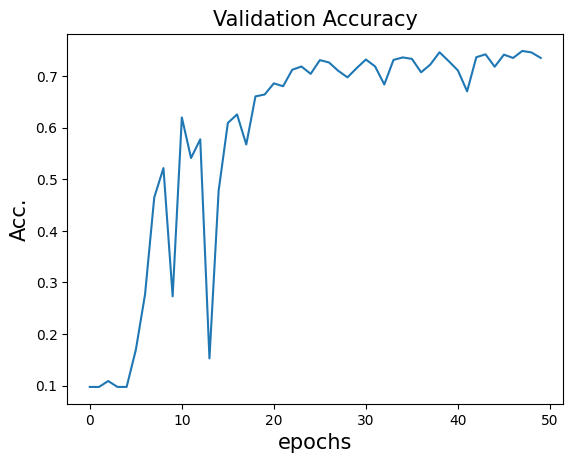

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

test accuracy 측정 결과 **80% 이상**이 나와야 한다.

In [21]:
my_mobilenet.evaluate(x_test,y_test)

313/313 [==============================] - 5s 13ms/step - loss: 1.0747 - accuracy: 0.7369


[1.0746521949768066, 0.7368999719619751]